In [28]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

In [29]:
file_path = "/Users/pdmcguckian/Documents/IoT/Project/SIoT/Data & Modelling/BLEData.csv"
data_set = pd.read_csv(file_path)
dataset = pd.DataFrame(data_set)
dataset.fillna(0)

print("Dimension of dataset: ", dataset.shape)
tmp_str = "Feature(attribute)     DataType"; print(tmp_str+"\n"+"-"*len(tmp_str))
print(dataset.dtypes)

Dimension of dataset:  (33781, 5)
Feature(attribute)     DataType
-------------------------------
_id             object
timeStampID      int64
rssiLVNGRM     float64
rssiBDRM       float64
rssiKTCHN      float64
dtype: object


In [30]:
dataset = dataset.drop(['_id'], axis=1)

for i in range(len(dataset['timeStampID'])):
    try:
        unix = dataset['timeStampID'][i]
        timestr = time.ctime(unix)[11:19]
        dataset['timeStampID'][i] = timestr
    except:
        dataset['timeStampID'][i] = 0

dataset.head()

/var/folders/nl/3ltpf26555bghcsvq18fzc340000gn/T/ipykernel_88872/1032976766.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['timeStampID'][i] = timestr
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,timeStampID,rssiLVNGRM,rssiBDRM,rssiKTCHN
0,12:00:00,-100.0,-100.0,-100.0
1,12:01:00,-100.0,-100.0,-100.0
2,12:02:00,-100.0,-100.0,-100.0
3,12:03:00,-100.0,-100.0,-100.0
4,12:04:00,-100.0,-100.0,-100.0


In [31]:
times = [[]]
bdrms = [[]]
ktchns = [[]]
lvngrms = [[]]

day = 0
for index, row in dataset.iterrows():
    if row['timeStampID'] == "12:00:00":
        day += 1
        print(row)
        times.append([])
        bdrms.append([])
        ktchns.append([])
        lvngrms.append([])

    times[day].append(row['timeStampID'])
    bdrms[day].append(row['rssiBDRM'])
    ktchns[day].append(row['rssiKTCHN'])
    lvngrms[day].append(row['rssiLVNGRM'])

timeStampID    12:00:00
rssiLVNGRM       -100.0
rssiBDRM         -100.0
rssiKTCHN        -100.0
Name: 0, dtype: object
timeStampID    12:00:00
rssiLVNGRM       -100.0
rssiBDRM         -100.0
rssiKTCHN        -100.0
Name: 1441, dtype: object
timeStampID    12:00:00
rssiLVNGRM       -100.0
rssiBDRM         -100.0
rssiKTCHN        -100.0
Name: 2884, dtype: object
timeStampID    12:00:00
rssiLVNGRM       -100.0
rssiBDRM         -100.0
rssiKTCHN        -100.0
Name: 4326, dtype: object
timeStampID    12:00:00
rssiLVNGRM       -100.0
rssiBDRM         -100.0
rssiKTCHN        -100.0
Name: 5767, dtype: object
timeStampID    12:00:00
rssiLVNGRM       -100.0
rssiBDRM         -100.0
rssiKTCHN        -100.0
Name: 7208, dtype: object
timeStampID    12:00:00
rssiLVNGRM       -100.0
rssiBDRM         -100.0
rssiKTCHN        -100.0
Name: 8648, dtype: object
timeStampID    12:00:00
rssiLVNGRM       -100.0
rssiBDRM         -100.0
rssiKTCHN        -100.0
Name: 10093, dtype: object
timeStampID    12:00:00
rs

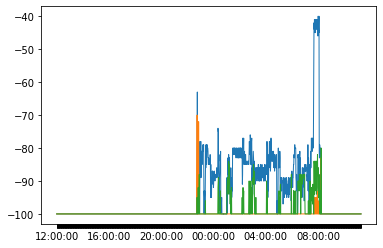

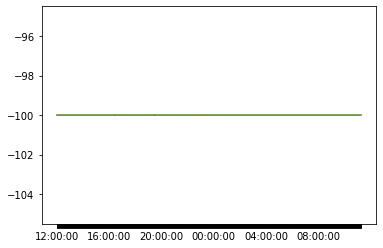

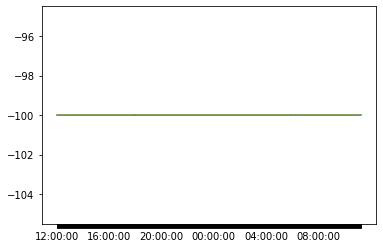

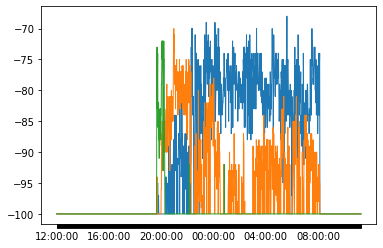

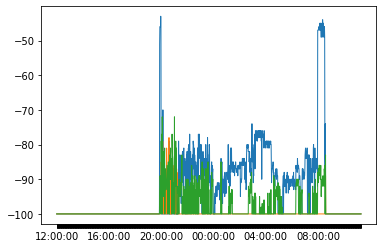

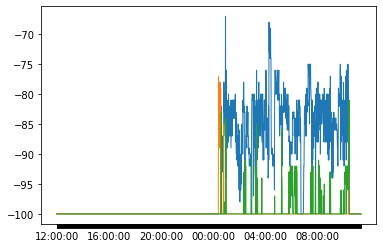

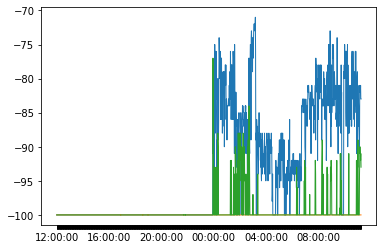

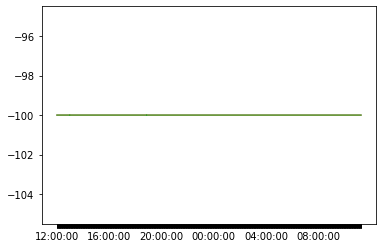

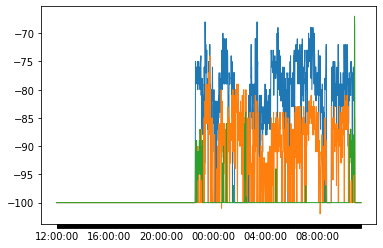

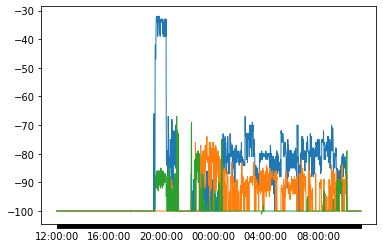

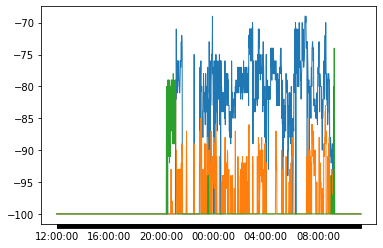

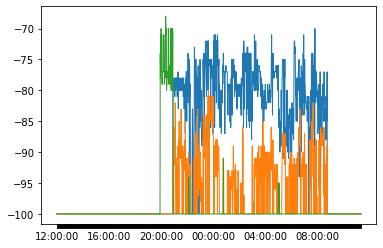

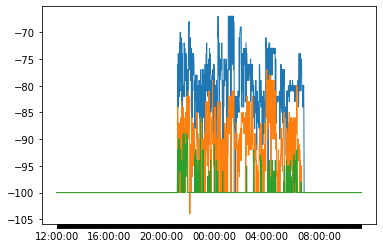

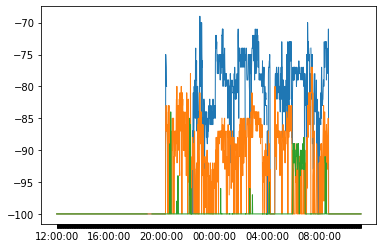

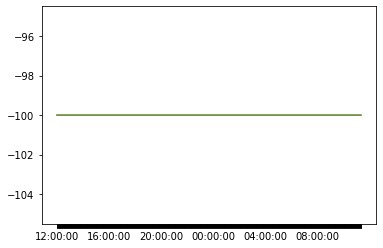

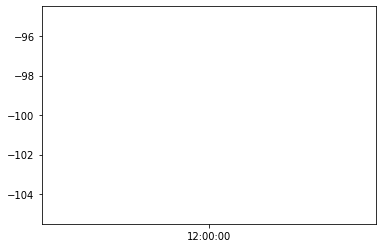

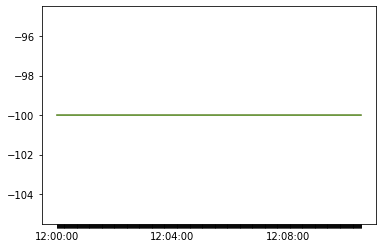

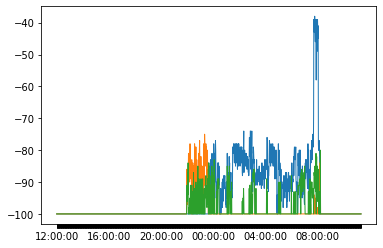

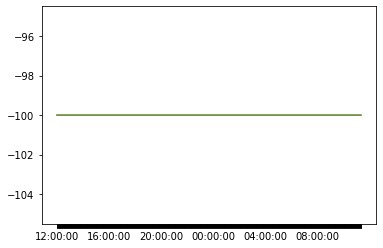

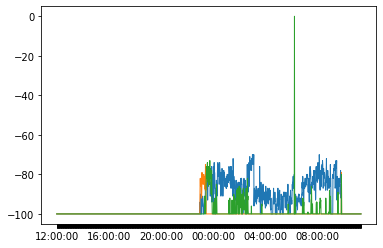

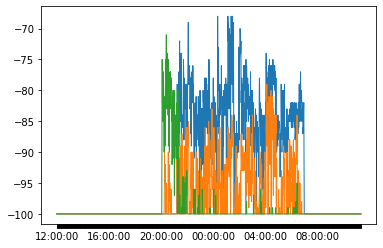

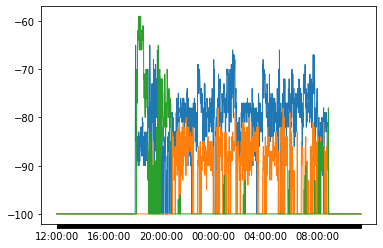

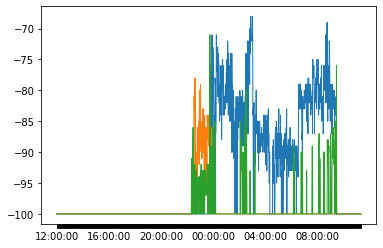

In [32]:
for i in range(1, len(times)-1):
    fig, ax = plt.subplots()
    ax.plot(times[i][:1400], bdrms[i][:1400], linewidth=1.0, label = "Bedroom")
    ax.plot(times[i][:1400], lvngrms[i][:1400], linewidth=1.0, label = "Living Room")
    ax.plot(times[i][:1400], ktchns[i][:1400], linewidth=1.0, label = "Kitchen")
    
    every_nth = 240
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    plt.show()

In [33]:
bdrmsbools = [[]]
ktchnsbools = [[]]
lvngrmsbools = [[]]
wybool = [[]]

for i in range(1, len(bdrms)):
    bdrms[i] = np.convolve(bdrms[i], np.ones(5)/5, mode='valid')
    ktchns[i] = np.convolve(ktchns[i], np.ones(5)/5, mode='valid')
    lvngrms[i] = np.convolve(lvngrms[i], np.ones(5)/5, mode='valid')

day = 0
for i in range(len(lvngrms)):
    for j in range(len(lvngrms[i])):
        bdrm = bdrms[i][j]
        lvngrm = lvngrms[i][j]
        ktchn = ktchns[i][j]

        if bdrm == -100 and ktchn == -100 and lvngrm == -100:
            wybool[day].append(1)
            ktchnsbools[day].append(0)
            bdrmsbools[day].append(0)
            lvngrmsbools[day].append(0)

        elif bdrm >= ktchn and bdrm >= lvngrm:
            wybool[day].append(0)
            ktchnsbools[day].append(0)
            bdrmsbools[day].append(1)
            lvngrmsbools[day].append(0)

        elif ktchn >= bdrm and ktchn >= lvngrm:
            wybool[day].append(0)
            ktchnsbools[day].append(1)
            bdrmsbools[day].append(0)
            lvngrmsbools[day].append(0)

        elif lvngrm >= bdrm and lvngrm >= ktchn:
            wybool[day].append(0)
            ktchnsbools[day].append(0)
            bdrmsbools[day].append(0)
            lvngrmsbools[day].append(1)

        if sum(wybool[-1]) == 1440:
            print()
            wybool.pop()
            ktchnsbools.pop()
            bdrmsbools.pop()
            lvngrmsbools.pop()
            day-=1
    day+=1
    wybool.append([])
    ktchnsbools.append([])
    bdrmsbools.append([])
    lvngrmsbools.append([])


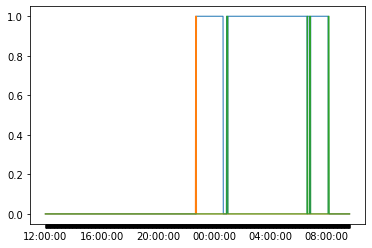

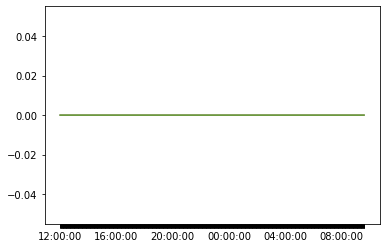

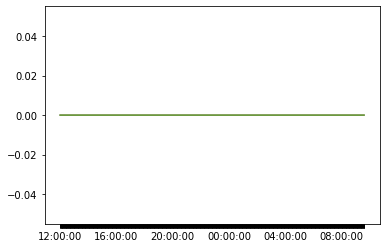

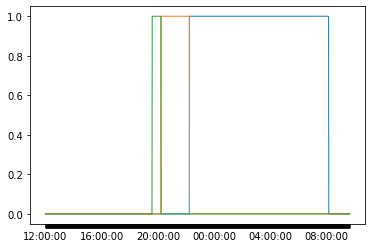

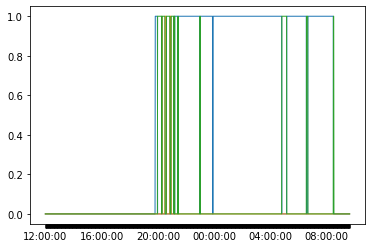

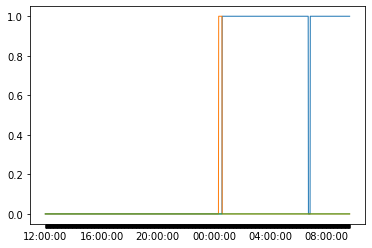

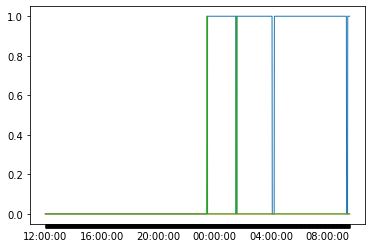

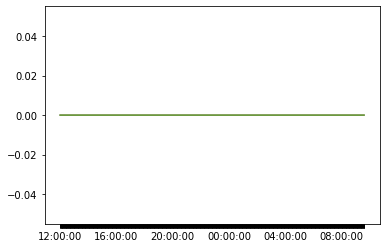

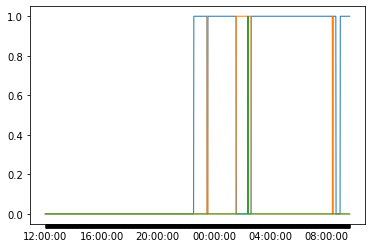

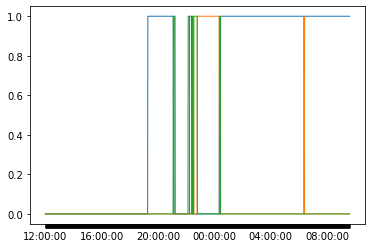

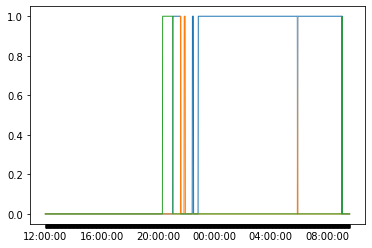

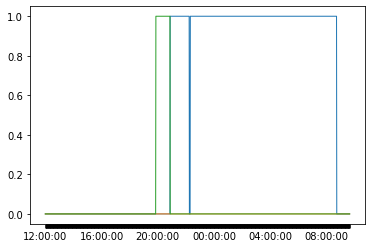

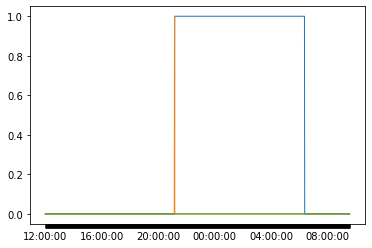

ValueError: x and y must have same first dimension, but have shapes (1300,) and (1239,)

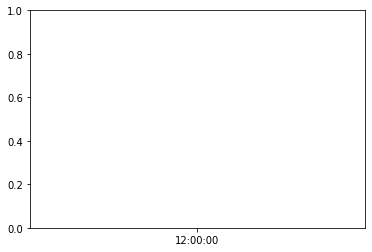

In [35]:

for i in range(1, len(wybool)):
    try:
        fig, ax = plt.subplots()
        ax.plot(times[i][:1300], bdrmsbools[i][:1300], linewidth=1.0, label = "Bedroom")
        ax.plot(times[i][:1300], lvngrmsbools[i][:1300], linewidth=1.0, label = "Living Room")
        ax.plot(times[i][:1300], ktchnsbools[i][:1300], linewidth=1.0, label = "Kitchen")
        
        every_nth = 240
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)

        plt.show()
    except:
        pass